# Лаба 2.2
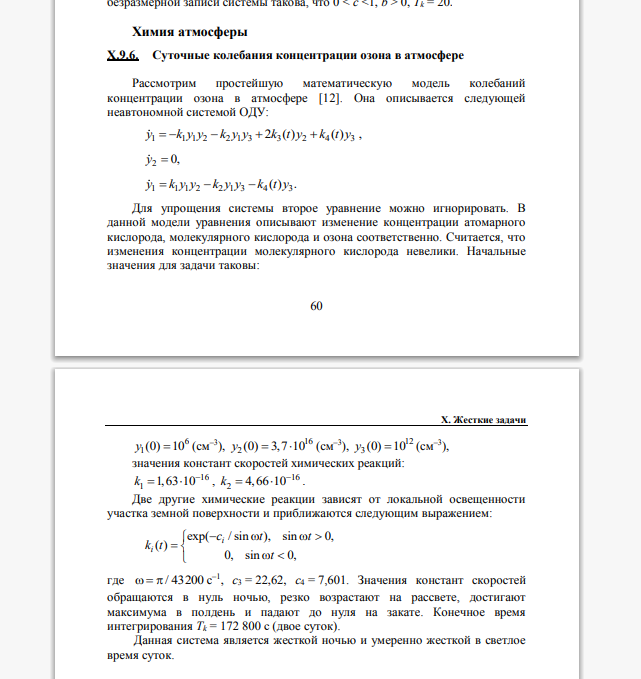

In [7]:
import numpy as np
import matplotlib.pyplot as plt

### Правая часть уравнений:


In [8]:
def f1(t, y, k):
    return -k[0] * y[0] * y[1] - k[1] * y[0] * y[2] + 2 * k[2](t) * y[1] + k[3](t) * y[2]

def f2(t, y, k):
    return 0

def f3(t, y, k):
    return k[0] * y[0] * y[1] - k[1] * y[0] * y[2] - k[3](t) * y[2]

def f(t, y, k):
    #  Векторизованная  функция  правой  части
    dy = np.zeros(3)
    dy[0] = -k[0] * y[0] * y[1] - k[1] * y[0] * y[2] + 2 * k[2](t) * y[1] + k[3](t) * y[2]
    dy[1] = 0
    dy[2] = k[0] * y[0] * y[1] - k[1] * y[0] * y[2] - k[3](t) * y[2]
    return dy

### Начальные условаия:

In [9]:
# Константы 
omega = np.pi / 43200  # c^-1
c1 = 22.62
c2 = 7.601

# Коэффициенты k
k1 = 1.63e-16
k2 = 4.66e-16
k3 = lambda t: (np.exp(-c1 / np.sin(omega * t)) if np.sin(omega * t) > 1e-2 else 0)
k4 = lambda t: (np.exp(-c2 / np.sin(omega * t)) if np.sin(omega * t) > 1e-2 else 0)
k = [k1, k2, k3, k4]

# Начальные условия
t_span = [0, 36*24*1]
y0 = np.array([1e6, 3.7e16, 1e12])  # см^-3
h: float = 1

### Решение Методом Рунге-Кутты 3 порядка с использованием Метода Ньютона для решения промежуточной системы

In [10]:
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

def jacobian(t, y, K, k, c, A, h):
    df1_dy = [-k[0] * y[1] - k[1] * y[2], -k[0] * y[0] + 2 * k[2](t), -k[1] * y[0] + k[3](t)]
    df2_dy = [0, 0, 0]
    df3_dy = [k[0] * y[1] - k[1] * y[2], k[0] * y[0], -k[1] * y[0] - k[3](t)]
    J = np.zeros((3, 3))

    J[0, 0] = df1_dy[0] * h*A[0, 0] - 1 
    J[0, 1] = df1_dy[1] * h*A[0, 1] 
    J[0, 2] = df1_dy[2] * h*A[0, 2] 
    J[1, 0] = df2_dy[0]
    J[1, 1] = df2_dy[1] - 1
    J[1, 2] = df2_dy[2]
    J[2, 0] = df3_dy[0] * h*A[2, 0]
    J[2, 1] = df3_dy[1] * h*A[2, 1]
    J[2, 2] = df3_dy[2] * h*A[2, 2] - 1 

    return J


def implicit_runge_kutta_3(f, t_span, y0, k, h, max_iter=2000, tol=1e-6):
    # Неявный метод Рунге-Кутты 3 порядка.
    c = np.array([0, 1/2, 1])
    A = np.array([[0, 0, 0], [1/2, 0, 0], [-1, 2, 0]])
    b = np.array([1/6, 2/3, 1/6])
    koef = 0.01
    t0, tf = t_span
    t = np.arange(t0, tf + h, h)
    N = len(t)
    y = np.zeros((N, 3))
    y[0] = y0

    for i in range(1, N):
        def F(K, t, y, k, c, A, h):
            return np.array([
                f(t + c[0] * h, y + h * (A @ K)[0], k)[0] - K[0],
                f(t + c[1] * h, y + h * (A @ K)[1], k)[1] - K[1],
                f(t + c[2] * h, y + h * (A @ K)[2], k)[2] - K[2],
            ])

        # метод Ньютона
        K = np.ones(3)

        for _ in range(max_iter):
            J = jacobian(t[i-1], y[i-1], K, k, c, A, h)
            K = K - koef * np.linalg.inv(J) @ F(K, t[i-1], y[i-1], k, c, A, h)
            if np.allclose(F(K, t[i-1], y[i-1], k, c, A, h), 0, atol=tol):
                break
    
        y[i] = y[i-1] + h * (b @ K)
        print("Y: ", y[i])
        print("T: ", t[i])
    return t, y

### Явный метод

In [11]:
def RungeKutteOneIterate(t: float, y: np.ndarray, h: float, f, k):
    k1 = h * f(t, y, k)
    k2 = h * f(t + h / 3, y + k1 / 3, k)
    k3 = h * f(t + 2 * h / 3, y + 2 * k2 / 3, k)
    y_next = y + (k1 + 3 * k3) / 4
    return y_next

def RungeKutte(t_span, y0, h: float, f, k):
    t0, tf = t_span
    t = np.arange(t0, tf + h, h)
    N = len(t)
    y = np.zeros((N, len(y0)))
    y[0] = y0

    for i in range(1, N):
        y[i] = RungeKutteOneIterate(t[i-1], y[i-1], h, f, k)
        print("RI: ", y[i])

    return t, y


### Решение системы:

In [12]:
t, y = implicit_runge_kutta_3(f, t_span, y0, k, h)
sol = solve_ivp(lambda t, y: f(t, y, k), t_span, y0, method='Radau', t_eval=np.arange(t_span[0], t_span[1], h))
t, y = RungeKutte(t_span, y0, h, f, k)

for i in sol.y.T:
    print("YY: ", i)

Y:  [7.06200478e+06 3.70000000e+16 1.00000606e+12]
T:  1
Y:  [4.98719115e+07 3.70000000e+16 1.00004887e+12]
T:  2
Y:  [3.52195673e+08 3.70000004e+16 1.00035120e+12]
T:  3
Y:  [2.48720728e+09 3.70000025e+16 1.00248621e+12]
T:  4
Y:  [1.75646575e+10 3.70000176e+16 1.01756366e+12]
T:  5
Y:  [1.24041088e+11 3.70001240e+16 1.12404009e+12]
T:  6
Y:  [8.75948454e+11 3.70008759e+16 1.87594745e+12]
T:  7
Y:  [6.18444076e+12 3.70061844e+16 7.18443976e+12]
T:  8
Y:  [4.35991192e+13 3.70435991e+16 4.45991182e+13]
T:  9
Y:  [3.04116441e+14 3.73041164e+16 3.05116440e+14]
T:  10
Y:  [1.95279041e+15 3.89527904e+16 1.95379041e+15]
T:  11
Y:  [2.66338984e+15 3.96633898e+16 2.66438984e+15]
T:  12
Y:  [-4.60654432e+15  3.23934557e+16 -4.60554432e+15]
T:  13
Y:  [-3.96541012e+16 -2.65410116e+15 -3.96531012e+16]
T:  14
Y:  [-2.49252675e+19 -2.48882675e+19 -2.49252665e+19]
T:  15
Y:  [-7.70481632e+30 -7.70481632e+30 -7.70481632e+30]
T:  16
Y:  [-6.99787662e+76 -6.99787662e+76 -6.99787662e+76]
T:  17
Y:  [-4.

/tmp/ipykernel_360936/4226193864.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dy[0] = -k[0] * y[0] * y[1] - k[1] * y[0] * y[2] + 2 * k[2](t) * y[1] + k[3](t) * y[2]
/tmp/ipykernel_360936/4226193864.py:15: RuntimeWarning: overflow encountered in scalar multiply
  dy[2] = k[0] * y[0] * y[1] - k[1] * y[0] * y[2] - k[3](t) * y[2]
/tmp/ipykernel_360936/4226193864.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  dy[2] = k[0] * y[0] * y[1] - k[1] * y[0] * y[2] - k[3](t) * y[2]
/tmp/ipykernel_360936/2618905161.py:49: RuntimeWarning: invalid value encountered in matmul
  K = K - koef * np.linalg.inv(J) @ F(K, t[i-1], y[i-1], k, c, A, h)


Y:  [nan nan nan]
T:  19
Y:  [nan nan nan]
T:  20
Y:  [nan nan nan]
T:  21
Y:  [nan nan nan]
T:  22
Y:  [nan nan nan]
T:  23
Y:  [nan nan nan]
T:  24
Y:  [nan nan nan]
T:  25
Y:  [nan nan nan]
T:  26
Y:  [nan nan nan]
T:  27
Y:  [nan nan nan]
T:  28
Y:  [nan nan nan]
T:  29
Y:  [nan nan nan]
T:  30
Y:  [nan nan nan]
T:  31
Y:  [nan nan nan]
T:  32
Y:  [nan nan nan]
T:  33
Y:  [nan nan nan]
T:  34
Y:  [nan nan nan]
T:  35
Y:  [nan nan nan]
T:  36
Y:  [nan nan nan]
T:  37
Y:  [nan nan nan]
T:  38
Y:  [nan nan nan]
T:  39
Y:  [nan nan nan]
T:  40
Y:  [nan nan nan]
T:  41
Y:  [nan nan nan]
T:  42
Y:  [nan nan nan]
T:  43
Y:  [nan nan nan]
T:  44
Y:  [nan nan nan]
T:  45
Y:  [nan nan nan]
T:  46
Y:  [nan nan nan]
T:  47
Y:  [nan nan nan]
T:  48
Y:  [nan nan nan]
T:  49
Y:  [nan nan nan]
T:  50
Y:  [nan nan nan]
T:  51
Y:  [nan nan nan]
T:  52
Y:  [nan nan nan]
T:  53
Y:  [nan nan nan]
T:  54
Y:  [nan nan nan]
T:  55
Y:  [nan nan nan]
T:  56
Y:  [nan nan nan]
T:  57
Y:  [nan nan nan]
T:  58


/tmp/ipykernel_360936/4226193864.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  dy[0] = -k[0] * y[0] * y[1] - k[1] * y[0] * y[2] + 2 * k[2](t) * y[1] + k[3](t) * y[2]
/tmp/ipykernel_360936/4226193864.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  dy[0] = -k[0] * y[0] * y[1] - k[1] * y[0] * y[2] + 2 * k[2](t) * y[1] + k[3](t) * y[2]
/tmp/ipykernel_360936/4226193864.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  dy[2] = k[0] * y[0] * y[1] - k[1] * y[0] * y[2] - k[3](t) * y[2]
